In [2]:
from google.colab import drive
drive.mount("/content/drive")
file_path="/content/drive/My Drive/AI/NLP/PhishingEmailDetector/datasets/Phishing_Email.csv"

Mounted at /content/drive


In [3]:
#importing libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')
print("Libraries imported and NLTK data downloaded.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Libraries imported and NLTK data downloaded.


In [5]:
#reading the file and print first 10 rows
df=pd.read_csv(file_path)
print(df.head(10))

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   
5           5  global risk management operations sally congra...   
6           6  On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...   
7           7  entourage , stockmogul newsletter ralph velez ...   
8           8  we owe you lots of money dear applicant , afte...   
9           9  re : coastal deal - with exxon participation u...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
5      Safe Email  
6      Safe Email  
7  Phishing Email  
8  Phishing Email  
9      Safe Email  


In [6]:
#cleaning
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
# print(stop_words)

def clean_email(text):
  if not isinstance(text,str):
    return ""
  text=text.lower()

  text = re.sub(r'<.*?>', '', text)

  text = re.sub(r'http\S+|www\S+|https\S+', 'url_token', text)

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  #tokenizing
  words=text.split()
  cleanedWords=[stemmer.stem(word) for word in words if word not in stop_words]

  return " ".join(cleanedWords)

print("cleaning...")
df["cleaned_text"]=df["Email Text"].apply(clean_email)

print("cleaning complete")
print(df[['Email Text', 'cleaned_text']].head(50))

print("\n--- ALL COLUMN NAMES ---")
print(df.columns)


cleaning...
cleaning complete
                                           Email Text  \
0   re : 6 . 1100 , disc : uniformitarianism , re ...   
1   the other side of * galicismos * * galicismo *...   
2   re : equistar deal tickets are you still avail...   
3   \nHello I am your hot lil horny toy.\n    I am...   
4   software at incredibly low prices ( 86 % lower...   
5   global risk management operations sally congra...   
6   On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...   
7   entourage , stockmogul newsletter ralph velez ...   
8   we owe you lots of money dear applicant , afte...   
9   re : coastal deal - with exxon participation u...   
10  make her beg you to give it to her everynight ...   
11  URL: http://www.newsisfree.com/click/-5,830431...   
12  begin forwarded text Date: Wed, 25 Sep 2002 13...   
13  re : fyi - wellhead portfolio who is considere...   
14  rmmla / ads * * * * * * * * papers solicited f...   
15  re : testing ir & fx var nick and winston , i ...   
1

In [7]:
# --- STEP 3: VECTORIZATION ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

# 1. Define Label Mapping
# We must convert 'Safe Email' and 'Phishing Email' to 0 and 1
label_mapping = {'Safe Email': 0, 'Phishing Email': 1}

# Map the 'Email Type' column to create a new numeric column
df['label_num'] = df['Email Type'].map(label_mapping)

# Check if mapping worked (Should show counts for 0 and 1)
print("--- LABEL COUNTS ---")
print(df['label_num'].value_counts())

# 2. Handle Missing Values
# If the mapping failed for any row (e.g., a label typo), drop it
if df['label_num'].isnull().sum() > 0:
    print(f"\n⚠️ Dropping {df['label_num'].isnull().sum()} rows with unknown labels...")
    df = df.dropna(subset=['label_num'])

# 3. Define Input (X) and Target (y)
X = df['cleaned_text']
y = df['label_num']

# 4. Split Data (80% Train, 20% Test)
# random_state=42 ensures the split is the same every time you run it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- DATA SPLIT ---")
print(f"Training Emails: {len(X_train)}")
print(f"Testing Emails:  {len(X_test)}")

# 5. Apply TF-IDF Vectorization
print("\nVectorizing... (Learning top 5000 words)")
# max_features=5000 limits the vocabulary to the top 5,000 most frequent words
tfidf = TfidfVectorizer(max_features=5000)

# FIT on Training data, TRANSFORM both
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Training Matrix Shape: {X_train_tfidf.shape}")
print(f"✅ Testing Matrix Shape:  {X_test_tfidf.shape}")
# Shape format: (Number of Emails, 5000)

# 6. Save the Vectorizer
# We save this so we can process new emails later in the exact same way
save_path = '/content/drive/My Drive/tfidf_vectorizer.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(tfidf, f)
print(f"\n✅ Vectorizer saved to: {save_path}")

--- LABEL COUNTS ---
label_num
0    11322
1     7328
Name: count, dtype: int64

--- DATA SPLIT ---
Training Emails: 14920
Testing Emails:  3730

Vectorizing... (Learning top 5000 words)
✅ Training Matrix Shape: (14920, 5000)
✅ Testing Matrix Shape:  (3730, 5000)

✅ Vectorizer saved to: /content/drive/My Drive/tfidf_vectorizer.pkl


Initializing Random Forest Model...
Training the model... (This may take 1-2 minutes)
✅ Model trained successfully!

Running predictions on Test Data...

🎯 Model Accuracy: 96.17%

--- DETAILED REPORT ---
              precision    recall  f1-score   support

        Safe       0.97      0.96      0.97      2273
    Phishing       0.95      0.96      0.95      1457

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



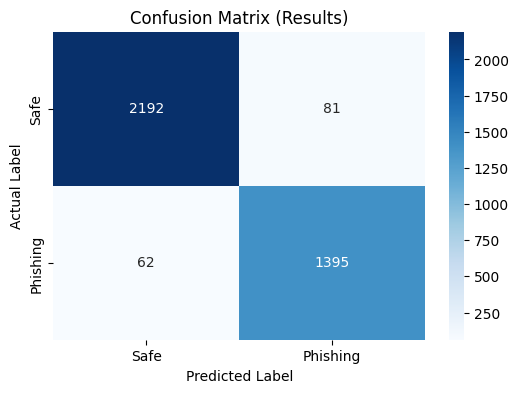


✅ Model saved to: /content/drive/My Drive/phishing_model.pkl


In [8]:
# --- STEP 4: MODEL TRAINING ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib # Used for saving the model

# 1. Initialize the Model
# n_estimators=100 means we are using 100 different decision trees (The "Forest")
print("Initializing Random Forest Model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the Model (Fit)
# This is where the heavy lifting happens. It learns the relationship between Words and Labels.
print("Training the model... (This may take 1-2 minutes)")
model.fit(X_train_tfidf, y_train)
print("✅ Model trained successfully!")

# 3. Test the Model (Predict)
# We test it on the 'exam' data (Test set) that it has never seen before
print("\nRunning predictions on Test Data...")
predictions = model.predict(X_test_tfidf)

# 4. Evaluate Performance
accuracy = accuracy_score(y_test, predictions)
print(f"\n🎯 Model Accuracy: {accuracy * 100:.2f}%")

print("\n--- DETAILED REPORT ---")
# This shows precision (false positives) and recall (false negatives)
print(classification_report(y_test, predictions, target_names=['Safe', 'Phishing']))

# 5. Visualize Confusion Matrix
# This graph shows exactly where the model made mistakes
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Phishing'],
            yticklabels=['Safe', 'Phishing'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Results)')
plt.show()

# 6. Save the Model
# We save it so we can use it later without retraining
model_path = '/content/drive/My Drive/phishing_model.pkl'
joblib.dump(model, model_path)
print(f"\n✅ Model saved to: {model_path}")

In [9]:
# --- STEP 5: PREDICTION FUNCTION ---
import joblib
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 1. Load the Saved Model and Vectorizer
# We load the "Brain" (Model) and the "Dictionary" (Vectorizer)
print("Loading model and vectorizer...")
model = joblib.load('/content/drive/My Drive/phishing_model.pkl')
with open('/content/drive/My Drive/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# 2. Define the Cleaning Function (Must be same as before!)
# We need to clean the new email just like we cleaned the training data
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', 'url_token', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(cleaned_words)

# ---------------------------------------------------------
# 3. INPUT YOUR EMAIL HERE
# ---------------------------------------------------------
email_to_test = """
Subject: Project Meeting Reschedule

Hi Team,

I hope you are having a good week. Can we reschedule our 2 PM meeting to 3 PM?
I have a conflict with another call.

Let me know if that time works for everyone. I attached the updated slide deck for your review.

Best regards,
Sarah
"""

# ---------------------------------------------------------
# 4. RUN PREDICTION
# ---------------------------------------------------------

# A. Clean the input
cleaned_input = clean_text(email_to_test)
print(f"\nOriginal: {email_to_test.strip()}")
print(f"Cleaned:  {cleaned_input}")

# B. Vectorize the input
# Note: We use [cleaned_input] because transform expects a list
input_vector = vectorizer.transform([cleaned_input])

# C. Predict
prediction = model.predict(input_vector)
probability = model.predict_proba(input_vector) # Get percentage confidence

# D. Show Result
result = "PHISHING" if prediction[0] == 1 else "SAFE"
confidence = probability[0][prediction[0]] * 100

print("-" * 30)
print(f"🛑 VERDICT: {result}")
print(f"📊 Confidence: {confidence:.2f}%")
print("-" * 30)

Loading model and vectorizer...

Original: Subject: Project Meeting Reschedule

Hi Team,

I hope you are having a good week. Can we reschedule our 2 PM meeting to 3 PM?
I have a conflict with another call.

Let me know if that time works for everyone. I attached the updated slide deck for your review.

Best regards,
Sarah
Cleaned:  subject project meet reschedul hi team hope good week reschedul pm meet pm conflict anoth call let know time work everyon attach updat slide deck review best regard sarah
------------------------------
🛑 VERDICT: SAFE
📊 Confidence: 93.00%
------------------------------


      🚀 MODEL PERFORMANCE REPORT      
✅ Accuracy:   0.9617  (Overall Correctness)
🎯 Precision:  0.9451  (When it predicts Phishing, is it right?)
🔍 Recall:     0.9574  (Did it catch all Phishing emails?)
⚖️ F1-Score:   0.9512  (Balance of Precision & Recall)
📈 ROC-AUC:    0.9937  (Distinction capability)
----------------------------------------

--- DETAILED CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Safe (0)       0.97      0.96      0.97      2273
Phishing (1)       0.95      0.96      0.95      1457

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



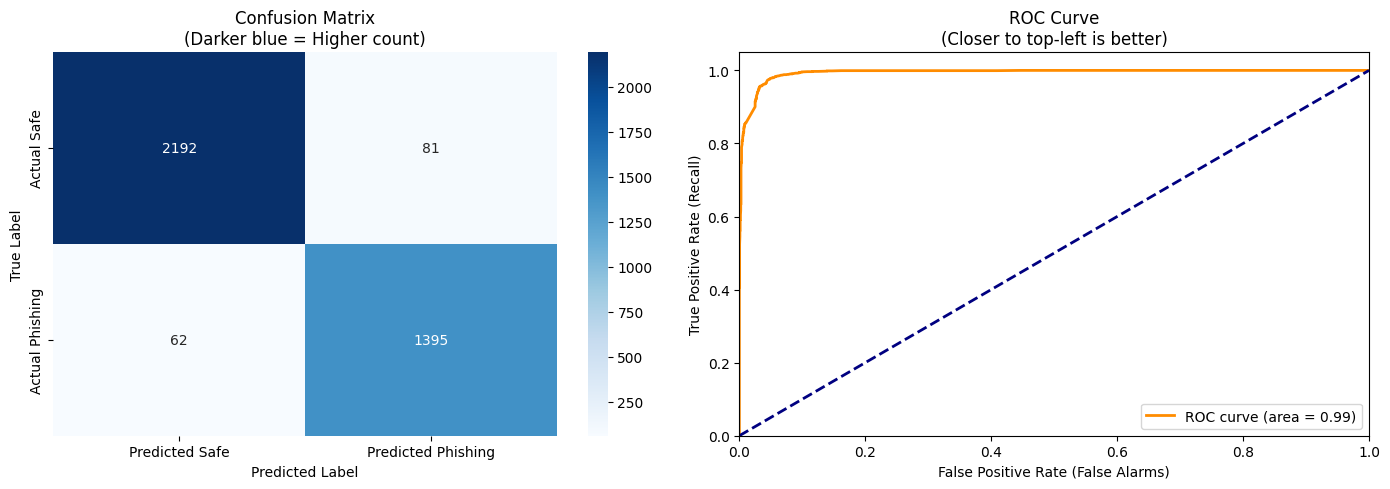

In [11]:
# --- STEP 6: ADVANCED MODEL VALIDATION ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Run Predictions on the Test Set
# We predict the class (0 or 1) AND the probability (0.0 to 1.0)
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1] # Probability of being Phishing (Class 1)

# 2. Calculate Key Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 3. Print the Summary Table
print("="*40)
print("      🚀 MODEL PERFORMANCE REPORT      ")
print("="*40)
print(f"✅ Accuracy:   {accuracy:.4f}  (Overall Correctness)")
print(f"🎯 Precision:  {precision:.4f}  (When it predicts Phishing, is it right?)")
print(f"🔍 Recall:     {recall:.4f}  (Did it catch all Phishing emails?)")
print(f"⚖️ F1-Score:   {f1:.4f}  (Balance of Precision & Recall)")
print(f"📈 ROC-AUC:    {roc_auc:.4f}  (Distinction capability)")
print("-" * 40)
print("\n--- DETAILED CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Safe (0)', 'Phishing (1)']))

# 4. VISUALIZATION 1: Confusion Matrix
# This shows exactly where the errors are happening
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Phishing'],
            yticklabels=['Actual Safe', 'Actual Phishing'])
plt.title('Confusion Matrix\n(Darker blue = Higher count)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 5. VISUALIZATION 2: ROC Curve
# Shows the trade-off between catching phishing vs. false alarms
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve\n(Closer to top-left is better)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()